In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


data = pd.read_excel('/content/data_set.xlsx')
data = data.iloc[:, :7]
data.head()

user_id  movie_1  movie_2  movie_3  movie_4  movie_5  movie_6
0        1      5.0      3.0      4.0      4.0      4.0      5.0
1        2      2.0      5.0      NaN      5.0      5.0      NaN
2        3      5.0      4.0      5.0      2.0      2.0      3.0
3        4      4.0      5.0      3.0      1.0      4.0      4.0
4        5      NaN      5.0      NaN      4.0      NaN      3.0

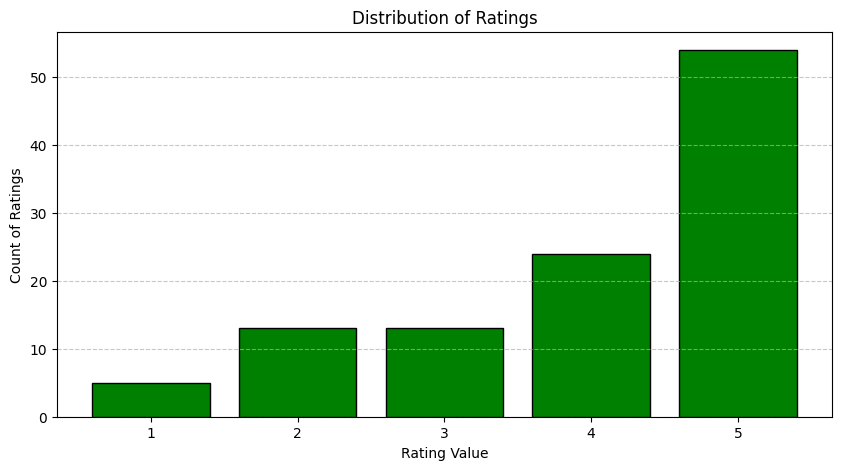

(20,
 6,
 0.09166666666666667,
 False,
 rating
 1.0    0.045872
 2.0    0.119266
 3.0    0.119266
 4.0    0.220183
 5.0    0.495413
 Name: count, dtype: float64,
 'movie_3',
 'movie_5')

In [38]:
Tn_users = data['user_id'].nunique()
Tn_movies = len(data.columns) - 1

ratings = data.set_index('user_id').stack().reset_index(name='rating')
ratings.columns = ['user_id', 'movie', 'rating']

ratings_count_per_movie = ratings['movie'].value_counts()
rating_distribution = ratings['rating'].value_counts().sort_index()


plt.figure(figsize=(10, 5))
plt.bar(rating_distribution.index, rating_distribution.values, color='green', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Count of Ratings')
plt.xticks(range(int(rating_distribution.index.min()), int(rating_distribution.index.max()) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

total_possible_ratings = Tn_users * Tn_movies
actual_ratings = ratings.shape[0]
sparsity = 1 - (actual_ratings / total_possible_ratings)

bias_level = rating_distribution / rating_distribution.sum()
bias_exists = bias_level.max() > 0.5

missing_ratings_count = data.set_index('user_id').isnull().sum()

highest_missing_movies = missing_ratings_count.nlargest(2)

m1, m2 = highest_missing_movies.index.tolist()

Tn_users, Tn_movies, sparsity, bias_exists, bias_level, m1, m2


In [39]:
sum_ratings = data.set_index('user_id').sum()
count_ratings = data.set_index('user_id').notnull().sum()
average_ratings = sum_ratings / count_ratings
missing_ratings_count = data.set_index('user_id').isnull().sum()

movie_status = pd.DataFrame({
    'average_rating': average_ratings,
    'missing_ratings': missing_ratings_count
})

highest_missing_movies = missing_ratings_count.nlargest(2)
m1, m2 = highest_missing_movies.index.tolist()

print("Movie status:\n", movie_status)
print(f"first target movie is : {m1}")
print(f"second target movie is : {m2}")

Movie status:
          average_rating  missing_ratings
movie_1        3.947368                1
movie_2        4.157895                1
movie_3        4.117647                3
movie_4        3.789474                1
movie_5        4.176471                3
movie_6        3.833333                2
first target movie is : movie_3
second target movie is : movie_5


In [21]:
df_movies = data.drop(columns=['user_id'])
average_ratings = df_movies.mean()

df_filled = data.copy()
df_filled[df_movies.columns] = df_filled[df_movies.columns].fillna(average_ratings)
filled_average_ratings = df_filled[df_movies.columns].mean()
differences = df_filled[df_movies.columns].subtract(filled_average_ratings)
mean_centered = differences.divide(differences.std(ddof=0), axis=1)
covariance_matrix_all_movies = df_filled[df_movies.columns].subtract(filled_average_ratings).cov()

print("average ratings :\n", average_ratings)
print("fill with  avg rating :\n", filled_average_ratings)
print("mean centre matrix:\n", mean_centered)
print("cov matrix for all movies :\n", covariance_matrix_all_movies)

average ratings :
 movie_1    3.947368
movie_2    4.157895
movie_3    4.117647
movie_4    3.789474
movie_5    4.176471
movie_6    3.833333
dtype: float64
fill with  avg rating :
 movie_1    3.947368
movie_2    4.157895
movie_3    4.117647
movie_4    3.789474
movie_5    4.176471
movie_6    3.833333
dtype: float64
mean centre matrix:
      movie_1   movie_2   movie_3   movie_4   movie_5   movie_6
0   0.874957 -0.937232 -0.107927  0.174359 -0.174430  0.977326
1  -1.618671  0.681623  0.000000  1.002562  0.814009  0.000000
2   0.874957 -0.127804  0.809452 -1.482048 -2.151308 -0.698090
3   0.043748  0.681623 -1.025306 -2.310251 -0.174430  0.139618
4   0.000000  0.681623  0.000000  0.174359  0.000000 -0.698090
5   0.043748 -0.127804 -0.107927  1.002562 -1.162869 -2.373505
6  -1.618671  0.681623 -0.107927 -0.653845  0.814009  0.977326
7   0.874957  0.681623  0.809452 -0.653845 -1.162869  0.977326
8   0.874957  0.681623 -1.942685  1.002562  0.814009  0.139618
9   0.874957  0.681623 -0.107927  1

In [24]:
cov_matrix = covariance_matrix_all_movies
target_movies = ['movie_3', 'movie_5']
top_peers = {}
for movie in target_movies:
    covariance_values = cov_matrix[movie]
    sorted_peers = covariance_values.sort_values(ascending=False)
    sorted_peers = sorted_peers.drop(movie)
    top_2_peers = sorted_peers.head(2)
    top_4_peers = sorted_peers.head(4)
    top_peers[movie] = {
        'top_2_peers': top_2_peers.index.tolist(),
        'top_4_peers': top_4_peers.index.tolist()
    }

print("Top Peers for each Movie:\n")
for movie in top_peers:
    print(f"{movie}:")
    print(f"Top 2 Peers: {top_peers[movie]['top_2_peers']}")
    print(f"Top 4 Peers: {top_peers[movie]['top_4_peers']}")
    print('\n')

Top Peers for each Movie:

movie_3:
Top 2 Peers: ['movie_1', 'movie_5']
Top 4 Peers: ['movie_1', 'movie_5', 'movie_4', 'movie_6']


movie_5:
Top 2 Peers: ['movie_6', 'movie_3']
Top 4 Peers: ['movie_6', 'movie_3', 'movie_4', 'movie_1']




In [29]:
df_peers = df[top_peers['movie_3']['top_2_peers'] + top_peers['movie_5']['top_2_peers']]

print(df_peers.head())

df_peers_filled = df_peers.fillna(df_peers.mean())
pca = PCA(n_components=1)
reduced_ratings = pca.fit_transform(df_peers_filled)
df_reduced = pd.DataFrame(reduced_ratings, columns=['reduced_dimension'])

df_reduced['user_id'] = data['user_id']
print("\n reduced dimensional space for each user (Top 2 Peers):")
print(df_reduced)


   movie_1  movie_5  movie_6  movie_3
0      5.0      4.0      5.0      4.0
1      2.0      5.0      NaN      NaN
2      5.0      2.0      3.0      5.0
3      4.0      4.0      4.0      3.0
4      NaN      NaN      3.0      NaN

 reduced dimensional space for each user (Top 2 Peers):
    reduced_dimension  user_id
0           -0.004328        1
1           -1.382536        2
2            1.805085        3
3           -0.559355        4
4            0.479106        5
5            1.726114        6
6           -2.107616        7
7            0.556359        8
8           -0.451903        9
9            1.819326       10
10          -0.414522       11
11          -3.196448       12
12           1.508471       13
13          -0.309523       14
14           0.358616       15
15           0.703304       16
16          -0.309523       17
17          -2.569431       18
18           0.265405       19
19           2.083398       20


In [42]:
def predict_ratings(df, top_peers, target_item):
    ratings_for_peers = df[top_peers].mean(axis=1)
    predicted_rating = ratings_for_peers.mean()
    return predicted_rating

target_movies = ['movie_3', 'movie_5']

top_2_peers = {}

for movie in target_movies:
    covariance_values = cov_matrix[movie]
    sorted_peers = covariance_values.sort_values(ascending=False)
    sorted_peers = sorted_peers.drop(movie)
    top_2_peers[movie] = sorted_peers.head(2).index.tolist()

predicted_ratings = {}

for movie in target_movies:
    movie_predictions = []
    top_peers_for_movie = top_2_peers[movie]

    for user_id in df.index:
        if pd.isna(df.loc[user_id, movie]):
            predicted_rating = predict_ratings(df, top_peers_for_movie, movie)
            movie_predictions.append((user_id, predicted_rating))

    predicted_ratings[movie] = movie_predictions

for movie, predictions in predicted_ratings.items():
    print(f"\npredicted Ratings for {movie}:")
    for user_id, predicted_rating in predictions:
        print(f"User {user_id}: Predicted Rating = {predicted_rating}")



predicted Ratings for movie_3:
User 1: Predicted Rating = 4.026315789473684
User 4: Predicted Rating = 4.026315789473684
User 15: Predicted Rating = 4.026315789473684

predicted Ratings for movie_5:
User 4: Predicted Rating = 3.9444444444444446
User 10: Predicted Rating = 3.9444444444444446
User 15: Predicted Rating = 3.9444444444444446
